# Intel Image Competition - Autoencoders
## CS3400 - Final Project
------------------------------------------------------------------------
Authors: Luke Harwood, Kevin Paganini   
Date: 10/12/2022   
Description: In this notebook, Luke and I use an Autoencoder to try and find a latent representation   
for the Intel Image classification dataset. The dataset consists of 14034 training instances, 3000 test instances,   
and 7301 prediction instances. The plan is to use an autoencoder to find latent representations of the images and then use some sort of classification algorithm to assign labels to each image. The dataset consist of images of six different classes: buildings, forests, glaciers, mountains, seas, streets

Link to dataset: https://www.kaggle.com/datasets/puneet6060/intel-image-classification


### Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob as gb
import cv2
import tensorflow as tf
import keras


## Helper function to make figures look pretty
def make_pretty(ax, title='', x_label='', y_label='', img=False):
    ax.set_title(title, fontsize=20)
    ax.set_xlabel(x_label, fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    if img:
        ax.axis('off')
        
    return ax


# paths

base_train_path = os.path.join("intel_image", "seg_train", "seg_train")
train_building_path = os.path.join(base_train_path, "buildings")
train_forest_path = os.path.join(base_train_path, "forest")
train_glacier_path = os.path.join(base_train_path, "glacier")
train_mountain_path = os.path.join(base_train_path, "mountain")
train_sea_path = os.path.join(base_train_path, "sea")
train_street_path  = os.path.join(base_train_path, "street")
base_test_path = os.path.join("intel_image", "seg_test", "seg_test")
base_pred_path = os.path.join("intel_image", "seg_pred", "seg_pred")


### Total number of training instances for each class

In [3]:


                     
test_total_file_count = 0   
for dir in os.listdir(base_test_path):
    print(f'Total number of test {dir} instances: {len(os.listdir(os.path.join(base_test_path, dir)))}')  
    test_total_file_count += len(os.listdir(os.path.join(base_test_path, dir)))
    


train_total_file_count = 0
for dir in os.listdir(base_train_path):
    print(f'Total number of train {dir} instances: {len(os.listdir(os.path.join(base_train_path, dir)))}')
    train_total_file_count += len(os.listdir(os.path.join(base_train_path, dir)))


print('\n')
print(f'Total number of train instances: {train_total_file_count}')
print(f'Total number of test instances: {test_total_file_count}')
print(f'{train_total_file_count / (train_total_file_count + test_total_file_count)} training instances')
print(f'{test_total_file_count / (train_total_file_count + test_total_file_count)} test instances')

files = gb.glob(pathname= str(base_pred_path +'/*.jpg'))
print(f'Total number of prediction instances: {len(files)}')

Total number of test buildings instances: 437
Total number of test forest instances: 474
Total number of test glacier instances: 553
Total number of test mountain instances: 525
Total number of test sea instances: 510
Total number of test street instances: 501
Total number of train buildings instances: 2191
Total number of train forest instances: 2271
Total number of train glacier instances: 2404
Total number of train mountain instances: 2512
Total number of train sea instances: 2274
Total number of train street instances: 2382


Total number of train instances: 14034
Total number of test instances: 3000
0.8238816484677703 training instances
0.17611835153222966 test instances
Total number of prediction instances: 7301


### Displaying some of the pictures


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot: title={'center': 'Street'}>

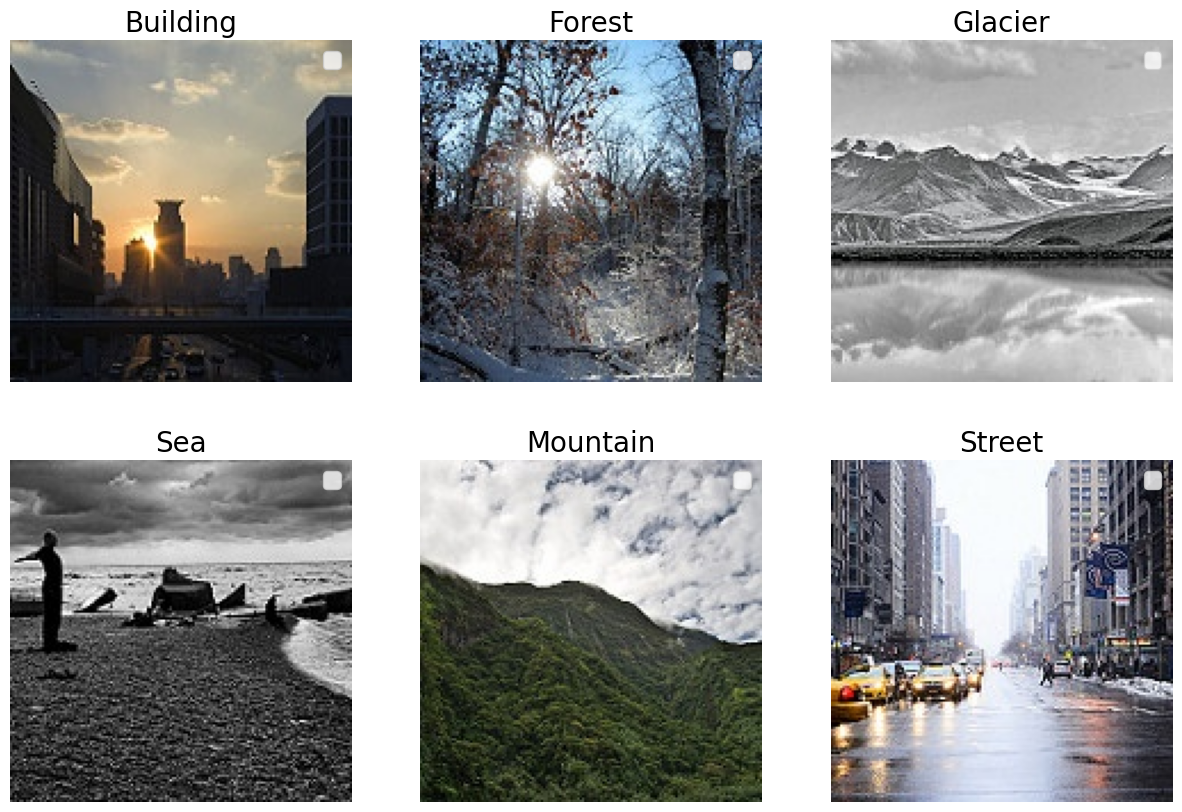

In [12]:
import matplotlib.image as img

building_image = img.imread(os.path.join(train_building_path, "55.jpg"))
forest_image = img.imread(os.path.join(train_forest_path, "114.jpg"))
glacier_image = img.imread(os.path.join(train_glacier_path, "40.jpg"))
sea_image = img.imread(os.path.join(train_sea_path, "207.jpg"))
mountain_image = img.imread(os.path.join(train_mountain_path, "155.jpg"))
street_image = img.imread(os.path.join(train_street_path, "37.jpg"))

fig, ax = plt.subplots(figsize=(15, 10), ncols=3, nrows=2)
ax[0,0].imshow(building_image)
make_pretty(ax[0,0], 'Building', img=True)
ax[0,1].imshow(forest_image)
make_pretty(ax[0,1], 'Forest', img=True)
ax[0,2].imshow(glacier_image)
make_pretty(ax[0,2], 'Glacier', img=True)
ax[1,0].imshow(sea_image)
make_pretty(ax[1,0], 'Sea', img=True)
ax[1,1].imshow(mountain_image)
make_pretty(ax[1,1], 'Mountain', img=True)
ax[1,2].imshow(street_image)
make_pretty(ax[1,2], 'Street', img=True)


### Shapes of the images

### Training image shapes

In [5]:
# Finds shape of every image in subdirectory
def find_shape(path):
    size = []
    print(f'Directories scanned:') 

    for folder in os.listdir(path):
        print(str(path + '\\' + folder + '/*.jpg'))
        files = gb.glob(pathname=str(path +'\\'+ folder + '/*.jpg'))
        for file in files: 
            image = plt.imread(file)
            size.append(image.shape)
    return pd.Series(size).value_counts()


find_shape(base_train_path)


Directories scanned:
intel_image\seg_train\seg_train\buildings/*.jpg
intel_image\seg_train\seg_train\forest/*.jpg
intel_image\seg_train\seg_train\glacier/*.jpg
intel_image\seg_train\seg_train\mountain/*.jpg
intel_image\seg_train\seg_train\sea/*.jpg
intel_image\seg_train\seg_train\street/*.jpg


(150, 150, 3)    13986
(113, 150, 3)        7
(111, 150, 3)        3
(135, 150, 3)        3
(144, 150, 3)        2
(123, 150, 3)        2
(142, 150, 3)        2
(146, 150, 3)        2
(143, 150, 3)        2
(134, 150, 3)        2
(136, 150, 3)        2
(108, 150, 3)        2
(105, 150, 3)        1
(97, 150, 3)         1
(131, 150, 3)        1
(147, 150, 3)        1
(81, 150, 3)         1
(145, 150, 3)        1
(141, 150, 3)        1
(100, 150, 3)        1
(103, 150, 3)        1
(76, 150, 3)         1
(120, 150, 3)        1
(102, 150, 3)        1
(119, 150, 3)        1
(133, 150, 3)        1
(115, 150, 3)        1
(124, 150, 3)        1
(110, 150, 3)        1
(149, 150, 3)        1
(140, 150, 3)        1
dtype: int64

### Testing image shapes

In [6]:
find_shape(base_test_path)

Directories scanned:
intel_image\seg_test\seg_test\buildings/*.jpg
intel_image\seg_test\seg_test\forest/*.jpg
intel_image\seg_test\seg_test\glacier/*.jpg
intel_image\seg_test\seg_test\mountain/*.jpg
intel_image\seg_test\seg_test\sea/*.jpg
intel_image\seg_test\seg_test\street/*.jpg


(150, 150, 3)    2993
(141, 150, 3)       1
(110, 150, 3)       1
(76, 150, 3)        1
(149, 150, 3)       1
(72, 150, 3)        1
(131, 150, 3)       1
(81, 150, 3)        1
dtype: int64

### Prediction image shapes

In [7]:
size = []

files = gb.glob(pathname=str(base_pred_path + '/*.jpg'))
for file in files:
    image = plt.imread(file)
    size.append(image.shape)
    
        
        
pd.Series(size).value_counts()

(150, 150, 3)    7288
(133, 150, 3)       1
(139, 150, 3)       1
(108, 150, 3)       1
(124, 150, 3)       1
(131, 150, 3)       1
(144, 150, 3)       1
(149, 150, 3)       1
(143, 150, 3)       1
(129, 150, 3)       1
(100, 150, 3)       1
(112, 150, 3)       1
(126, 150, 3)       1
(374, 500, 3)       1
dtype: int64

### What do we do about these irregular shape? Do we just drop them?

### Finding max RGB values to know what the output shape should be


### Preparing the data

For now we will keep the original image size. Lets see if Rosie can handle it


In [8]:
X_train = []
y_train = []

############################################
# Original size is 150, 150, 3
resample_x = 128
resample_y = 128
resample_z = 3
############################################
counter = 0
for folder in os.listdir(base_train_path):
    print(str(base_train_path + '\\' + folder + '/*.jpg'))
    files = gb.glob(pathname=str(base_train_path +'\\'+ folder + '/*.jpg'))
    for file in files: 
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ###########################################
        # interpolation could be changed too, just arbitrary right now
        image = cv2.resize(image,(resample_x,resample_y), interpolation=cv2.INTER_AREA)
        ###########################################
        X_train.append(image)
        y_train.append(counter)
    counter += 1

intel_image\seg_train\seg_train\buildings/*.jpg
intel_image\seg_train\seg_train\forest/*.jpg
intel_image\seg_train\seg_train\glacier/*.jpg
intel_image\seg_train\seg_train\mountain/*.jpg
intel_image\seg_train\seg_train\sea/*.jpg
intel_image\seg_train\seg_train\street/*.jpg


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Label: 1


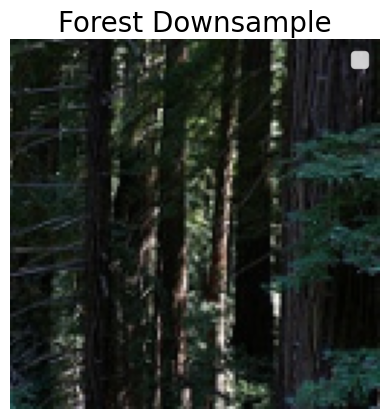

In [9]:
## Lets see what the downsampling did
fig, ax = plt.subplots()

ax.imshow(X_train[2500])
make_pretty(ax, 'Forest Downsample', img=True)
print(f'Label: {y_train[2500]}')

### Shuffling the data set

In [10]:

# For shuffling data set
X_train_full = np.asarray(X_train) / 255 # not sure if scaling is needed here
y_train_full = np.array(y_train)
indices = tf.range(start=0, limit=tf.shape(X_train_full)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)
shuffled_X_train = tf.gather(X_train_full, shuffled_indices)
shuffled_y_train = tf.gather(y_train_full, shuffled_indices)
print(X_train_full[0:50])

[[[[0.96862745 0.96862745 0.96078431]
   [0.96862745 0.96862745 0.96078431]
   [0.97254902 0.97254902 0.96470588]
   ...
   [0.97254902 0.97254902 0.97254902]
   [0.96862745 0.96862745 0.96470588]
   [0.96862745 0.96862745 0.96078431]]

  [[0.96470588 0.96470588 0.95686275]
   [0.96862745 0.96862745 0.96078431]
   [0.96862745 0.96862745 0.96078431]
   ...
   [0.97254902 0.97254902 0.97254902]
   [0.96862745 0.96862745 0.96470588]
   [0.96862745 0.96862745 0.96078431]]

  [[0.96470588 0.96470588 0.95686275]
   [0.96470588 0.96470588 0.95686275]
   [0.96862745 0.96862745 0.96078431]
   ...
   [0.97254902 0.97254902 0.97254902]
   [0.96862745 0.96862745 0.96470588]
   [0.96862745 0.96862745 0.96078431]]

  ...

  [[0.2        0.19607843 0.18823529]
   [0.22745098 0.22352941 0.21568627]
   [0.26666667 0.2627451  0.25490196]
   ...
   [0.25882353 0.23921569 0.22745098]
   [0.18431373 0.16470588 0.15294118]
   [0.25882353 0.23921569 0.22745098]]

  [[0.25882353 0.25490196 0.24705882]
   [0.1

### Train and validation split for training

In [11]:


X_train, X_valid = shuffled_X_train[:-1000], shuffled_X_train[-1000:]
y_train, y_valid = shuffled_y_train[:-1000], shuffled_y_train[-1000:]

print(f'X_train shape: {X_train.shape}')
print(f'X_train first sample shape: {X_train[0].shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_valid shape: {y_valid.shape}')






X_train shape: (13034, 128, 128, 3)
X_train first sample shape: (128, 128, 3)
y_train shape: (13034,)
y_valid shape: (1000,)


## Short rundown of the model of Autoencoders

Autoencoders simply learn to copy their inputs to their outputs. This may sound like a trivial task, but if we constrain networks in certain ways  
we can make this task a lot harder than copy and paste. One thing you could do is limit the size of the latent representations. One could also add noise   
tp the input of the model and ask the model to recreate the original image. Using these constraints, the model is forced to learn efficient ways of    
representing the data. In short, the coidngs are byproducts of the autoencoder learning the identity function under some constraints.     
(Not sure what identity function means)


Autoencoders are an unsupervised learning technique. This means they do not rely on labels to learn its weights. Instead, its output is compared to the original   
giving us our loss function. We can do pixel by pixel error and use that as the loss function.


Autoencoders are composed of a encoder (recognition) network, that encodes the inputs into a latent representation and a decoder (generative) network that decodes the latent representation   
hopefully close to its original form.


One interesting thing is that autoencoders resemble the architecture of a multi-layer perceptron. They also consist of an input that goes through a hidden layer and then is put    
through an output layer.

If the autoencoder uses multiple hidden layers, it is known as a deep autoencoder. Since autoencoders are very similar to neural networks they can be trained in the same fashion.   


The plan is to train a deep autoencoder to learn representations of the data. After that we will take of the decoding part of the model and replace it    
with a classification algorithm (TBD). 


Interestingly enough depending on what you want to achieve with your latent representation you can tune that layer. If you want to reduce features as much as possible so that you can   
feed those features to a classifier, you can choose a smaller latent representation, however you sacrifice the quality of the output. If you increase the size of the latent representation  
the model has more freedom to encode the image into the latent representation, making the output of the model more accurate. Tuning this layer you can find the balance you need between    
accuracy of output and dimensionality of the latent representation. This is why the latent representation layer is truly a hyperparameter of the model.


# I guess its model time

#### Arbitrary choices I made while setting up this problem


1. Scaling data between 0 and 1
2. Downsampling from 150, 150 to 100, 100
3. Layer sizes are arbitrary especially latent layer
4. Optimizer
5. activation function for each
6. loss function
7. Could try out different layers --> Conv2D


In [12]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

# Encoder network
# Shape to start is 100, 100, 3 so: 30000
# Latent layer with 30 is a hyperparameter that size can change
deep_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[resample_x, resample_y, resample_z]),
    keras.layers.Dense(4300, activation='relu'),
    keras.layers.Dense(600, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(30, activation='relu'),
])

# Decoder network
deep_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='relu', input_shape=[30]),
    keras.layers.Dense(600, activation='relu', input_shape=[100]),
    keras.layers.Dense(4300, activation='relu', input_shape=[600]),
    keras.layers.Dense(resample_x* resample_y* resample_z, activation='sigmoid', input_shape=[4300]),
    keras.layers.Reshape([resample_x, resample_y, resample_z])
])
# Output dim is also 100, 100, 3 so: 30000

# Putting it all together
deep_autoencoder = keras.models.Sequential([deep_encoder, deep_decoder])
# need pixel by pixel loss function here most likely
deep_autoencoder.compile(loss=tf.keras.losses.MeanAbsoluteError, optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), metrics=[rounded_accuracy])


# why is it showing 408 instead of full size
#history = deep_autoencoder.fit(X_train, X_train, shuffle=True, epochs=10, validation_data=(X_valid, X_valid))

### making a new imrpoved model


In [13]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

data_augmentation_layer = keras.Sequential([                                    
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal',input_shape=(resample_x, resample_y, 3)),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.15),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.15),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.15),
], name='data_augmentation')

deep_e = keras.Sequential()
deep_e.add(data_augmentation_layer)
deep_e.add(keras.layers.Conv2D(filters=32,kernel_size = (3, 3),strides=1,padding='same', activation='selu', kernel_initializer='lecun_normal'))

deep_e.add(keras.layers.MaxPool2D())   
deep_e.add(keras.layers.BatchNormalization())   
deep_e.add(keras.layers.Conv2D(filters=64,kernel_size = (3, 3),strides=1,padding='same', activation='selu', kernel_initializer='lecun_normal'))
deep_e.add(keras.layers.MaxPool2D())
deep_e.add(keras.layers.Conv2D(filters=128,kernel_size =(3, 3), strides=1,padding='same' ,activation='selu', kernel_initializer='lecun_normal'))
deep_e.add(keras.layers.MaxPool2D())
deep_e.add(keras.layers.Conv2D(filters=256,kernel_size =(3, 3), strides=1,padding='same', activation='selu', kernel_initializer='lecun_normal'))
deep_e.add(keras.layers.MaxPool2D())
deep_e.add(keras.layers.Conv2D(filters=512,kernel_size =(3, 3), strides=1,padding='same', activation='selu', kernel_initializer='lecun_normal'))
deep_e.add(keras.layers.GlobalMaxPool2D())
deep_e.add(keras.layers.Dense(512,activation='relu'))
deep_e.add(keras.layers.BatchNormalization())
deep_e.add(keras.layers.Dense(256,activation='relu'))
deep_e.add(keras.layers.Dense(128,activation='relu'))
deep_e.add(keras.layers.Dense(64,activation='sigmoid'))



deep_d = keras.Sequential([
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(512,activation='relu'),
    keras.layers.Reshape((16, 16, 2)),
    keras.layers.Conv2D(filters=512,kernel_size =(3, 3), strides=1,padding='same', activation='selu', kernel_initializer='lecun_normal'), 
    keras.layers.UpSampling2D(),
    keras.layers.Conv2D(filters=256,kernel_size =(3, 3), strides=1,padding='same', activation='selu', kernel_initializer='lecun_normal'), 
    keras.layers.UpSampling2D(),
    keras.layers.Conv2D(filters=128,kernel_size =(3, 3), strides=1,padding='same', activation='selu', kernel_initializer='lecun_normal'), 
    keras.layers.UpSampling2D(),
    keras.layers.Conv2D(filters=64,kernel_size =(3, 3), strides=1,padding='same', activation='selu', kernel_initializer='lecun_normal'), 
    keras.layers.BatchNormalization(),
    keras.layers.UpSampling2D(),
    keras.layers.Conv2D(filters=32, kernel_size =(3, 3), strides=1,padding='same', activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(filters=3, kernel_size =(3, 3), strides=1,padding='same', activation='selu', kernel_initializer='lecun_normal'),
])

deep_ae = keras.models.Sequential([deep_e, deep_d])


# deep_e.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(), metrics=[rounded_accuracy])
# deep_d.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(), metrics=[rounded_accuracy])

print(deep_ae.summary())

deep_ae.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(), metrics=[rounded_accuracy])



# Output dim is also 100, 100, 3 so: 30000

# Putting it all together
# deep_ae = keras.models.Sequential([deep_e, deep_d])
# # need pixel by pixel loss function here most likely
# deep_ae.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(), metrics=[rounded_accuracy])

# deep_ae.build(input_shape=(resample_x, resample_y, resample_z))

# deep_ae.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 64)                2005888   
                                                                 
 sequential_4 (Sequential)   (None, 128, 128, 3)       1756163   
                                                                 
Total params: 3,762,051
Trainable params: 3,760,323
Non-trainable params: 1,728
_________________________________________________________________
None


In [17]:

deep_d.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 128)               8320      
                                                                 
 dense_14 (Dense)            (None, 256)               33024     
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_15 (Dense)            (None, 512)               131584    
                                                                 
 reshape_1 (Reshape)         (None, 16, 16, 2)         0         
                                                      

In [18]:
deep_e.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 32)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, None, None, 32)   128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    18496     
                                                      

In [16]:

history = deep_ae.fit(X_train, X_train, shuffle=True, epochs=10, validation_data=(X_valid, X_valid))
deep_ae.save(os.path.join('models', 'model4.h5'))

Epoch 1/10
  6/408 [..............................] - ETA: 1:39:09 - loss: 1.1531 - rounded_accuracy: 0.5435

KeyboardInterrupt: 

In [ ]:
history.history

{'loss': [0.028544282540678978,
  0.023189090192317963,
  0.022481072694063187,
  0.021970324218273163,
  0.021715542301535606,
  0.021418781951069832,
  0.021182162687182426,
  0.021078672260046005,
  0.020883072167634964,
  0.020792728289961815],
 'rounded_accuracy': [0.8189634084701538,
  0.8404857516288757,
  0.8435500860214233,
  0.8461230993270874,
  0.8472583293914795,
  0.8485909104347229,
  0.849830150604248,
  0.8503406047821045,
  0.851288378238678,
  0.8517782092094421],
 'val_loss': [0.023187711834907532,
  0.022582868114113808,
  0.0225381962954998,
  0.02162403054535389,
  0.021732021123170853,
  0.021085040643811226,
  0.021231941878795624,
  0.02130570076406002,
  0.020588696002960205,
  0.020872728899121284],
 'val_rounded_accuracy': [0.8393144011497498,
  0.8422365784645081,
  0.8406728506088257,
  0.8439880609512329,
  0.8453243374824524,
  0.8483093976974487,
  0.8474404215812683,
  0.8465584516525269,
  0.850153923034668,
  0.8493753671646118]}

1/1 [==============================] - 0s 50ms/step


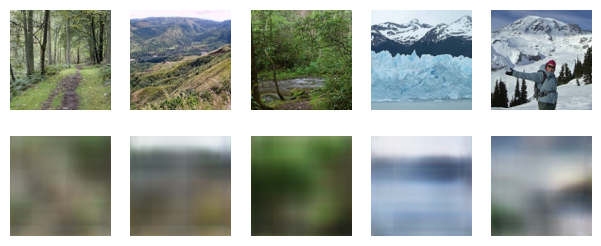

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    
    plt.axis("off")

def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        
def show_recon(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig, ax = plt.subplot(figsize=(15, 10))
    for i in range(n_images):
        plt.subplot()        

show_reconstructions(deep_ae, images=X_valid, n_images=5)

32/32 [==============================] - 2s 60ms/step


c:\CS3400_IPYNB\final_project\final_project_cs3400\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\CS3400_IPYNB\final_project\final_project_cs3400\venv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.08391633592545986, 0.9833750654011965, -0.05, 1.05)

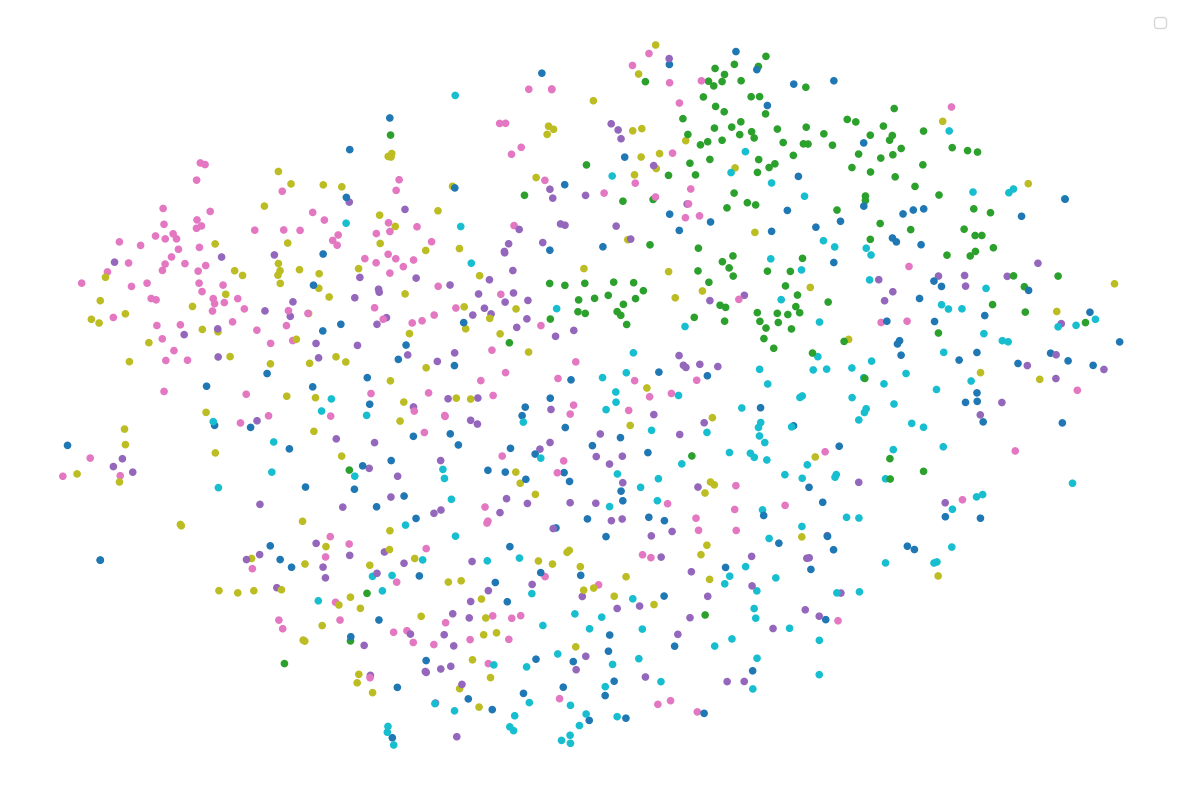

In [ ]:
from sklearn.manifold import TSNE
# print(X_valid[1])
X_valid_compressed = deep_e.predict(X_valid)
X_valid_compressed.shape
prepped_x = X_valid_compressed.reshape(1000, 324)
prepped_x.shape
tsne = TSNE()
X_valid_2D = tsne.fit_transform(prepped_x)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

fig, ax = plt.subplots(figsize=(15, 10))

ax.scatter(X_valid_2D[:,0], X_valid_2D[:,1], c=y_valid, s=20, cmap="tab10")
ax.legend(loc='best')
plt.axis('off')




## Wow much useful 

(1000, 3, 3, 36)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier



knn = KNeighborsClassifier()
knn.fit(prepped_x, y_valid)



KNeighborsClassifier()

In [ ]:
from sklearn.metrics import accuracy_score

pred = knn.predict(prepped_x)

acc = accuracy_score(pred, y_valid)

In [ ]:
acc

0.667

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X_train_compressed = deep_e.predict(X_train)
X_train_compressed.shape
prepped_train_x = X_train_compressed.reshape(13034, 324)

X_valid_compressed = deep_e.predict(X_valid)
prepped_val_x = X_valid_compressed.reshape(1000, 324)
X_valid_compressed.shape
prepped_x = X_valid_compressed.reshape(1000, 324)



ran_for_clas = RandomForestClassifier(max_depth=5)

ran_for_clas.fit(prepped_train_x, y_train)

pred = ran_for_clas.predict(prepped_val_x)

accuracy_score(pred, y_valid)

32/32 [==============================] - 3s 84ms/step


0.511